In [8]:
import librosa
import numpy as np
import pandas as pd
import json
import requests
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from pymongo import MongoClient
from bson.binary import Binary
import plotly.express as px

In [9]:
json_file_path = "./speechcrawling/records.json"
with open(json_file_path, 'r') as file:
    data = json.load(file)
df = pd.DataFrame(data)
df.head()

,original_url,record
0,https://freesound.org/people/kevp888/sounds/71...,https://cdn.freesound.org/previews/712/712632_...
1,https://freesound.org/people/Robinhood76/sound...,https://cdn.freesound.org/previews/712/712628_...
2,https://freesound.org/people/josefpres/sounds/...,https://cdn.freesound.org/previews/712/712630_...
3,https://freesound.org/people/newlocknew/sounds...,https://cdn.freesound.org/previews/712/712629_...
4,https://freesound.org/people/josefpres/packs/3...,https://cdn.freesound.org/previews/712/712630_...


In [10]:
def extract_record_name(url):
    url_sections= url.split("/")
    record = url_sections[-1]
    return record

In [11]:
def download_and_save(url):
    mp3_record = extract_record_name(url)
    file_path = "./mp3_records/" + mp3_record

    if os.path.exists(file_path):
        print(f"The file {mp3_record} already exists. Skipping download!")
    else:
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, "wb") as file:
                file.write(response.content)
            print(f"File {mp3_record} downloaded successfully.")
        else:
            print(f"Failed to download  {mp3_record}. Status code {response.status_code}")

In [12]:
for url in df['record']:
    download_and_save(url)


The file 712632_9034501-lq.mp3 already exists. Skipping download!
The file 712628_321967-lq.mp3 already exists. Skipping download!
The file 712630_5674468-lq.mp3 already exists. Skipping download!
The file 712629_5828667-lq.mp3 already exists. Skipping download!
The file 712630_5674468-lq.mp3 already exists. Skipping download!
The file 676694_5674468-lq.mp3 already exists. Skipping download!
The file 660950_5674468-lq.mp3 already exists. Skipping download!
The file 656816_5674468-lq.mp3 already exists. Skipping download!
The file 654671_5674468-lq.mp3 already exists. Skipping download!
The file 652687_5674468-lq.mp3 already exists. Skipping download!
The file 646029_5674468-lq.mp3 already exists. Skipping download!
The file 644491_5674468-lq.mp3 already exists. Skipping download!
The file 712627_1089955-lq.mp3 already exists. Skipping download!
The file 712628_321967-lq.mp3 already exists. Skipping download!
The file 702515_321967-lq.mp3 already exists. Skipping download!
The file 6338

In [13]:
def get_all_records(directory_path):
    files_and_directories = os.listdir(directory_path)
    records_list=[]
    for item in files_and_directories:
        full_path = os.path.join(directory_path, item)
        if os.path.isfile(full_path):
            records_list.append(item)
    return records_list

In [14]:
def display_raw_audio (path):
    audio, sample_rate = librosa.load(path, sr=None)
    time = librosa.times_like(audio, sr=sample_rate)
    plt.figure(figsize=(15, 5))
    plt.plot(time, audio, label='Waveform')
    plt.title('Raw Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    print("The sampled audio is returned as a numpy array (time series) and has", audio.shape[0], "samples.")
    print("The 10 randomly picked consecutive samples of the audio are:", audio[3000:3010])
    y_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    pd.Series(y_trimmed).plot(figsize=(10, 5),
                    lw=1,
                    title='Raw Audio Trimmed')
    plt.show()
    return audio

In [15]:
ipd.Audio('./mp3_records/626197_12579677-lq.mp3')

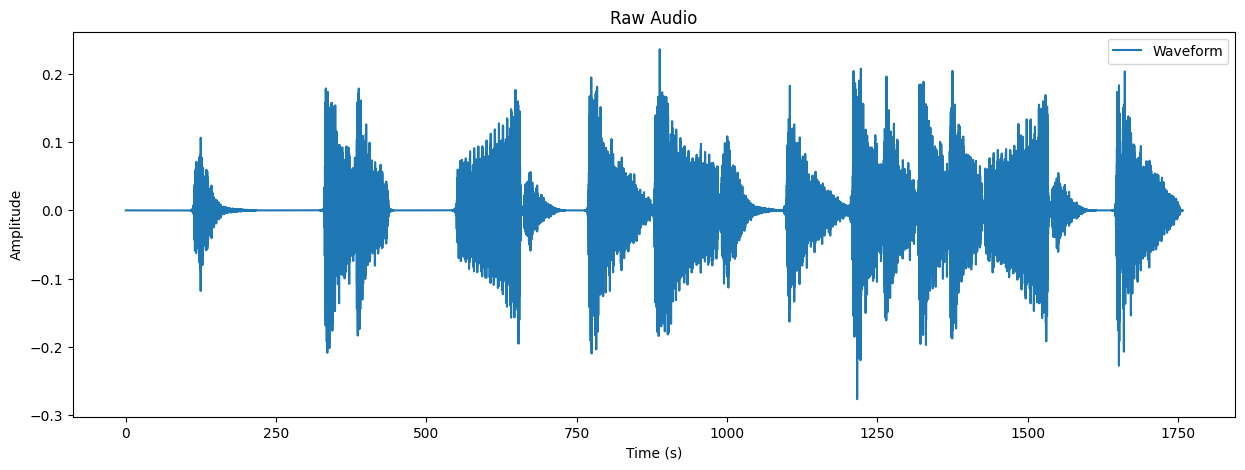

The sampled audio is returned as a numpy array (time series) and has 82393 samples.
The 10 randomly picked consecutive samples of the audio are: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


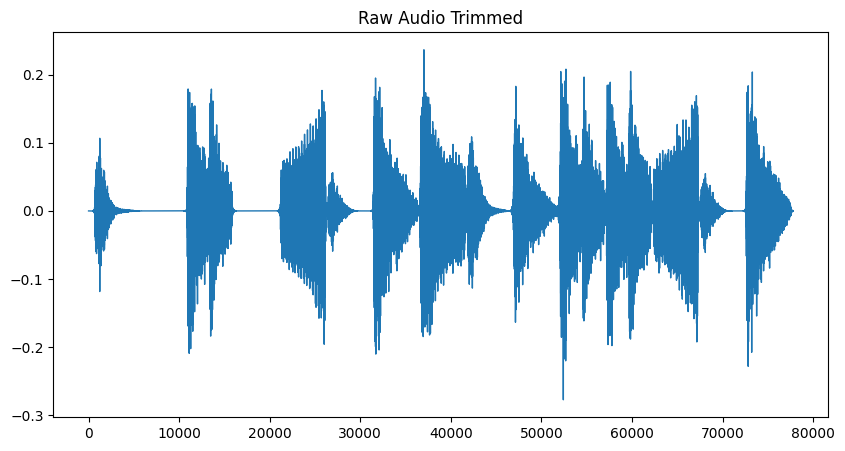

In [16]:
audio_626197_12579677=display_raw_audio('./mp3_records/157321_2305278-lq.mp3')

In [17]:
def display_spectogram(audio):
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_db.shape
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title('Spectogram', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()
    return S_db

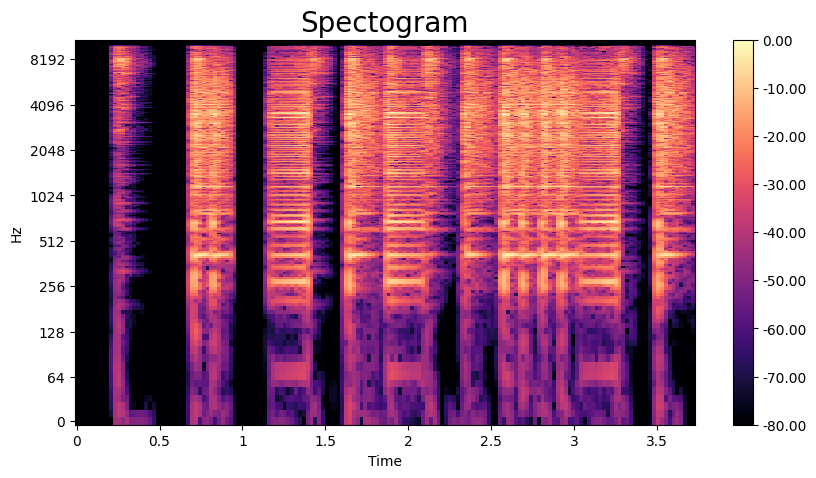

In [18]:
S_db_626197_12579677=display_spectogram(audio_626197_12579677)

feature matrix:[[  0.         105.21004879]
 [  0.39591338   3.37982017]
 [  0.79182677   3.41695426]
 ...
 [ -1.18774015   1.26853963]
 [ -0.79182677   3.41695426]
 [ -0.39591338   3.37982017]]


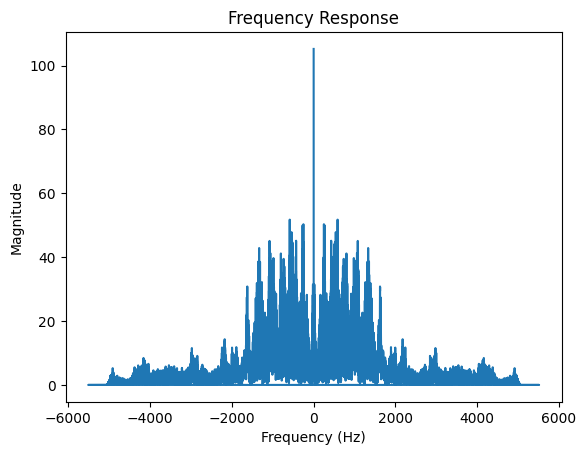

In [19]:
audio, sample_rate = librosa.load('./mp3_records/626197_12579677-lq.mp3', sr=None)
fft_result = np.fft.fft(audio)
frequencies = np.fft.fftfreq(len(fft_result), 1 / sample_rate)
feature_matrix = np.column_stack((frequencies, np.abs(fft_result)))
print(f'feature matrix:{feature_matrix}')
plt.plot(frequencies, np.abs(fft_result))
plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()


In [20]:
np.shape(feature_matrix)

(27847, 2)

In [21]:
def estimate_noise(signal, speech_estimate):
    # Estimate noise by subtracting the estimated speech from the original signal
    noise_estimate = signal - speech_estimate
    return noise_estimate

In [22]:
def calculate_snr(rms_audio, rms_noise):
    snr = 20 * np.log10( rms_audio / rms_noise )
    return snr

In [23]:
def calculate_rms(signal):
    return np.sqrt(np.mean(signal**2))

In [24]:
def calculate_MFCCs(audio,sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=50).T, axis=0)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    return mfcc,mfccs,mfccs_delta,mfccs_delta2

In [25]:
def calculate_autocorrelation(audio_signal):
    autocorr = np.correlate(audio_signal, audio_signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr /= np.max(autocorr)
    return autocorr

In [26]:
def calculate_fundamental_frequency(autocorr, sample_rate):
    peak_index = np.argmax(autocorr[1:]) + 1
    fundamental_freq = sample_rate / peak_index
    return fundamental_freq

In [27]:
def calculate_thd(audio_signal, fundamental_frequency):
    spectrum = np.fft.fft(audio_signal)

    fundamental_index = int(fundamental_frequency * len(audio_signal) / 44100) 
    
    # Calculate THD
    harmonic_indices = [2, 3, 4, 5]  # Consider harmonics up to the 5th
    thd = np.sqrt(np.sum(np.abs(spectrum[harmonic_indices])**2)) / np.abs(spectrum[fundamental_index]) * 100
    
    return thd

In [28]:
def calculate_dynamic_range_db( audio,rms_audio):
    peak_amplitude = np.max(np.abs(audio))
    dynamic_range_db = 20 * np.log10(peak_amplitude / rms_audio)
    return dynamic_range_db

In [29]:
def calculate_speech_level(audio,sample_rate):
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    speech_level = np.mean(spectral_centroid)
    return speech_level

In [30]:
def audio_features(file_path):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=None)
   
        # Calculate audio RMS
        rms_audio = calculate_rms(audio)

        #Calculate dynamic range of the audio signal in decibels
        dynamic_range_db=calculate_dynamic_range_db( audio,rms_audio)

        # Calculate Speech Level
        speech_level = calculate_speech_level(audio,sample_rate)

        # Pre-emphasis to the audio signal using a pre-emphasis filter
        speech_estimate = librosa.effects.preemphasis(audio)

        # Estimate noise
        noise_estimate = estimate_noise(audio, speech_estimate)

        # Calculate noise RMS
        rms_noise = calculate_rms(noise_estimate)

        # Calculate SNR ratio
        snr=calculate_snr(rms_audio,rms_noise)

        return speech_level, snr,rms_noise,sample_rate,dynamic_range_db,rms_audio
    
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

In [31]:
def create_dataframe(mp3_directory='./mp3_records/'):
    data_list=[]
    records_list=get_all_records(mp3_directory)
    for record in records_list:
        info_quality = audio_features('./mp3_records/' + record)
        if info_quality is not None:
            data_list.append({'record': record, 'speech_level': info_quality[0], 'snr': info_quality[1],\
                            'rms_noise':info_quality[2],'sample_rate':info_quality[3],\
                            'dynamic_range_db':info_quality[4],'rms_audio':info_quality[5]})
    data=pd.DataFrame(data_list) 
    return data

In [32]:
data=create_dataframe(mp3_directory='./mp3_records/')

c:\Users\rimai\Desktop\Data-Engineering-Working-Student-Position\venv\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=557
  warnings.warn(


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   record            739 non-null    object 
 1   speech_level      739 non-null    float64
 2   snr               739 non-null    float64
 3   rms_noise         739 non-null    float32
 4   sample_rate       739 non-null    int64  
 5   dynamic_range_db  739 non-null    float64
 6   rms_audio         739 non-null    float32
dtypes: float32(2), float64(3), int64(1), object(1)
memory usage: 34.8+ KB


In [34]:
data.describe()

,speech_level,snr,rms_noise,sample_rate,dynamic_range_db,rms_audio
count,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000
mean,1909.905642,0.264587,0.070421,25958.525034,18.677761,0.072600
std,1354.050951,0.000797,0.060955,6256.287357,5.917306,0.062849
min,32.342205,0.262317,0.000859,11025.000000,5.852084,0.000886
25%,886.538827,0.264565,0.027709,24000.000000,14.407704,0.028566
50%,1601.609160,0.264565,0.054589,24000.000000,17.249860,0.056278
75%,2594.146242,0.264566,0.096265,24000.000000,21.512735,0.099242
max,8985.782478,0.285969,0.445901,48000.000000,41.510086,0.460826


In [35]:
data['sample_rate'].value_counts()

sample_rate
24000    665
44100     52
48000     18
11025      2
22050      2
Name: count, dtype: int64

In [36]:
data['snr'].describe()

count    739.000000
mean       0.264587
std        0.000797
min        0.262317
25%        0.264565
50%        0.264565
75%        0.264566
max        0.285969
Name: snr, dtype: float64

In [37]:
data.to_csv('records.csv',index=False)

In [39]:
# Connect to MongoDB
client = MongoClient('localhost', 27017)
db = client['records']
metadata_collection = db['audios']

# Read and insert binary data for each audio file in the DataFrame
for index, row in data.iterrows():
    audio_file_path = f"./mp3_records/{row['record']}"
    
    # Read binary data from the audio file
    with open(audio_file_path, 'rb') as audio_file:
        audio_binary = Binary(audio_file.read())
    
    # Create a document with metadata and binary data
    record_document = {
        'filename': row['record'],
        'speech_level': row['speech_level'],
        'rms_audio':row['rms_audio'],
        'rms_noise': row['rms_noise'],
        'snr': row['snr'],
        'sample_rate': row['sample_rate'],
        'dynamic_range_db': row['dynamic_range_db'],
        'audio_data': audio_binary
    }

    # Insert the document into the MongoDB collection
    metadata_collection.insert_one(record_document)


In [40]:
# Connect to MongoDB
client = MongoClient('localhost', 27017)
db = client['records']
metadata_collection = db['audios']

# Example query: Find all documents in the collection
cursor = metadata_collection.find()

# Convert cursor to DataFrame for easy manipulation
result_df = pd.DataFrame(list(cursor))

# Display the resulting DataFrame
print(result_df)


                           _id               filename  speech_level       snr  \
0     656a7b846371bab619da8900  157321_2305278-lq.mp3   4783.927389  0.264565   
1     656a7b846371bab619da8901  157326_2305278-lq.mp3   4195.299024  0.264564   
2     656a7b846371bab619da8902      160229_288-lq.mp3   2693.866885  0.264564   
3     656a7b846371bab619da8903      160230_288-lq.mp3   6282.672665  0.264563   
4     656a7b846371bab619da8904      160231_288-lq.mp3   6608.544751  0.264562   
...                        ...                    ...           ...       ...   
2949  656ca3514d673ee19d3aa96d        9155_288-lq.mp3   3057.816615  0.264564   
2950  656ca3514d673ee19d3aa96e        9156_288-lq.mp3   2981.780100  0.264566   
2951  656ca3514d673ee19d3aa96f        9157_288-lq.mp3   2927.007814  0.264567   
2952  656ca3514d673ee19d3aa970        9158_288-lq.mp3   2636.605678  0.264566   
2953  656ca3514d673ee19d3aa971        9159_288-lq.mp3   3325.751229  0.264565   

      rms_noise  sample_rat

# Clustering

In [41]:
data_cluster=data[['rms_noise','speech_level','dynamic_range_db']]

In [42]:
data_cluster.head()

,rms_noise,speech_level,dynamic_range_db
0,0.027707,4783.927389,19.733253
1,0.190935,4195.299024,16.146494
2,0.021932,2693.866885,24.249692
3,0.019021,6282.672665,27.536585
4,0.009633,6608.544751,28.346336


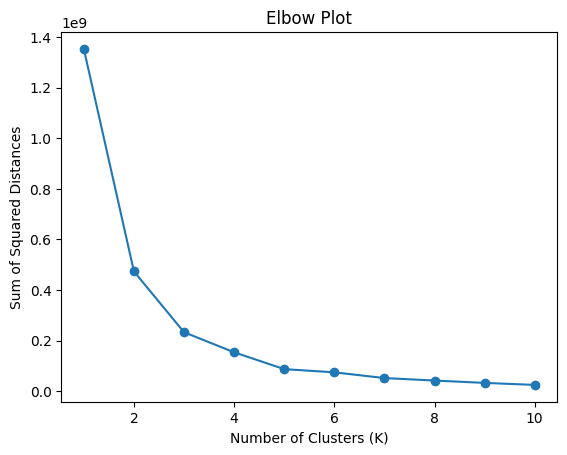

In [43]:
num_clusters_range = range(1, 11)  # Try clusters from 1 to 10
sse = [] 
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init='auto',max_iter=25)
    kmeans.fit(data_cluster)
    sse.append(kmeans.inertia_)

plt.plot(num_clusters_range, sse, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [44]:
kmeans = KMeans(n_clusters=2, random_state=42,n_init='auto',max_iter=15)
kmeans.fit(data_cluster)

KMeans(max_iter=15, n_clusters=2, n_init='auto', random_state=42)

In [45]:
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [46]:
data_cluster['label']=labels

C:\Users\rimai\AppData\Local\Temp\ipykernel_10900\4139323980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster['label']=labels


In [47]:
def labels_pie_plot(data_cluster):
    # Count the occurrences of each unique value in the 'label' column
    label_counts = data_cluster['label'].value_counts()

    # Create a Pie chart using Plotly
    fig = px.pie(
        label_counts,
        values=label_counts,
        names=label_counts.index,
        title='Pie Plot for Cluster Labels',
        labels={'label': 'Cluster Labels'},
        template='plotly',
    )

    # Save the plot as an image
    fig.write_image("./plots/Labels_pie_plot.png", format='png', scale=4)

    # Show the plot
    fig.show()


In [48]:
labels_pie_plot(data_cluster)

In [49]:
def clusters_visualization(data_cluster):
    plt.scatter(data_cluster.iloc[:, 0], data_cluster.iloc[:, 1], c=labels, cmap='viridis', edgecolors='k', alpha=0.7)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=20, label='Cluster Centers')
    plt.title('K-Means Clustering')
    plt.xlabel('rms_noise')
    plt.ylabel('speech_level')
    plt.legend()

    # Save the plot before displaying it
    plt.savefig("./plots/kmeans_clustering_plot.png", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


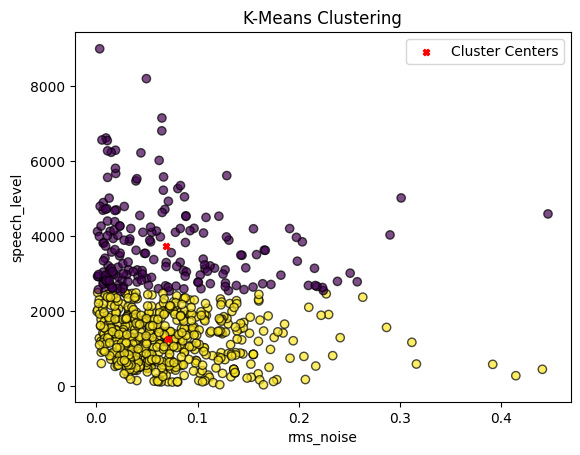

In [50]:
clusters_visualization(data_cluster)

In [51]:
# Assuming data_cluster is a DataFrame with three columns: col1, col2, col3
fig = go.Figure()

# Add 3D scatter plot for data points
fig.add_trace(go.Scatter3d(
    x=data_cluster['rms_noise'],
    y=data_cluster['speech_level'],
    z=data_cluster['dynamic_range_db'],
    mode='markers',
    marker=dict(
        size=8,
        color=labels,  # assuming labels is a list/array specifying the cluster for each point
        colorscale='viridis',
        opacity=0.7,
        line=dict(color='black', width=1)
    )
))

# Add cluster centers as red X markers
fig.add_trace(go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color='red',
        symbol='x'
    ),
    name='Cluster Centers'
))

# Set axis labels
fig.update_layout(
    scene=dict(
        xaxis=dict(title='rms_noise'),
        yaxis=dict(title='speech_level'),
        zaxis=dict(title='dynamic_range_db')
    )
)

# Set plot title
fig.update_layout(title='K-Means Clustering')

# Show the plot
fig.show()
